In [84]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from xgboost.sklearn import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import Imputer,StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

import pickle
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2250b3110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa224e60610>]], dtype=object)

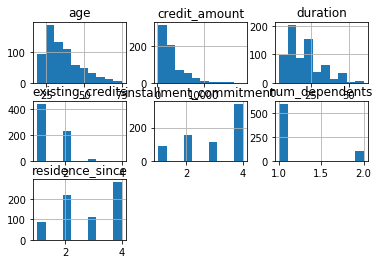

In [85]:
df = pd.read_csv('train_examen.csv')
Z = pd.read_csv('test_examen.csv')
df.hist()

In [86]:
df.columns

Index([u'checking_status', u'duration', u'credit_history', u'purpose',
       u'credit_amount', u'savings_status', u'employment',
       u'installment_commitment', u'personal_status', u'other_parties',
       u'residence_since', u'property_magnitude', u'age',
       u'other_payment_plans', u'housing', u'existing_credits', u'job',
       u'num_dependents', u'own_telephone', u'foreign_worker', u'class'],
      dtype='object')

In [87]:
var_disc= [u'checking_status', u'credit_history', u'purpose', u'savings_status',
       u'employment', u'personal_status', u'other_parties',
       u'property_magnitude', u'other_payment_plans', u'housing', u'job',
       u'own_telephone', u'foreign_worker',  u'existing_credits', u'num_dependents',u'installment_commitment', u'residence_since']
var_cont = [ u'duration',  u'credit_amount', u'age']
obj = 'class'

In [89]:
df['ID']=1
Z['ID']=1

In [90]:
##Cambiar todo a números 
le = preprocessing.LabelEncoder()
df[var_disc+[obj]] = df[var_disc+[obj]].apply(le.fit_transform)
Z[var_disc]=Z[var_disc].apply(le.fit_transform)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,ID
0,3,6.0,1,4,250.0,3,0,1,0,2,...,41.0,0,1,1,3,0,0,1,1,1
1,1,6.0,1,6,1169.0,4,3,3,3,2,...,67.0,1,1,1,1,0,1,1,1,1
2,0,30.0,3,3,3832.0,2,2,1,2,2,...,22.0,1,1,0,1,0,0,1,1,1
3,0,9.0,3,4,3195.0,4,0,0,0,2,...,33.0,1,1,0,3,0,0,1,1,1
4,3,9.0,1,4,2134.0,2,0,3,3,2,...,48.0,1,1,2,1,0,1,1,1,1


In [95]:
from math import log
from __future__ import division

def WoEfd(X,Z, var, obj, ID):
    Y = X.copy()
    W = Z.copy()
    IV = 0
    a = Y.pivot_table(aggfunc='count',columns=obj,fill_value=0, index=var,values=ID[0]).reset_index()
    a.loc[-1] =["TOTAL", sum(a[0]), sum(a[1])]
    for y in set(Y[var].values):
            goods = int(a[a[var]==y][1])/int(a[a[var]=='TOTAL'][1])
            bads = a[a[var]==y][0]/int(a[a[var]=='TOTAL'][0])
            d = log(bads/goods)
            IV += float((bads-goods)*d)
            Y[var].replace(y,d,inplace = True)
            W[var].replace(y,d,inplace = True)
    print a 
    print "IV total de "+ str(IV)
    return (Y,W)
def WoEfc(X, var, obj, ID, bins):
    Y = X.copy()
    IV = []
    for i in bins:
        Y[var] = pd.cut(X[var], bins = i)
        a = Y.pivot_table(aggfunc='count',columns=obj,fill_value=0, index=var,values=ID[0]).reset_index()
        a.loc[-1] =["TOTAL", sum(a[0]), sum(a[1])]
        IV.append(0)
        for y in set(Y[var].values):
            goods = int(a[a[var]==y][1])/int(a[a[var]=='TOTAL'][1])
            bads = a[a[var]==y][0]/int(a[a[var]=='TOTAL'][0])
            d = log(bads/goods)
            IV[-1] += float((bads-goods)*d)
        print "IV con "+str(i) + " bins es " + str(IV[-1])
    armax = np.argmax(IV)
    print "Se el maximiza el IV con "+ str(bins[armax]) + " bins"
    Y[var] = pd.cut(X[var], bins = bins[armax])
    a = Y.pivot_table(aggfunc='count',columns=obj,fill_value=0, index=var,values=ID[0]).reset_index()
    a.loc[-1] =["TOTAL", sum(a[0]), sum(a[1])]
    for y in set(Y[var].values):
            goods = int(a[a[var]==y][1])/int(a[a[var]=='TOTAL'][1])
            bads = a[a[var]==y][0]/int(a[a[var]=='TOTAL'][0])
            d = log(bads/goods)
            Y[var].replace(y,d,inplace = True)
    print a 
    return Y

In [92]:
for x in var_disc:
    df, Z  = WoEfd(X=df, Z= Z,var=x, obj = [obj], ID =['ID'])

0      3.000000
1      1.000000
2      0.398829
3      0.398829
4      3.000000
5      3.000000
6      3.000000
7      3.000000
8      3.000000
9      3.000000
10     0.398829
11     3.000000
12     3.000000
13     0.398829
14     3.000000
15     1.000000
16     1.000000
17     3.000000
18     3.000000
19     3.000000
20     1.000000
21     3.000000
22     2.000000
23     1.000000
24     1.000000
25     3.000000
26     0.398829
27     1.000000
28     1.000000
29     3.000000
         ...   
670    2.000000
671    3.000000
672    0.398829
673    1.000000
674    3.000000
675    1.000000
676    2.000000
677    0.398829
678    3.000000
679    3.000000
680    2.000000
681    1.000000
682    3.000000
683    0.398829
684    1.000000
685    1.000000
686    3.000000
687    3.000000
688    3.000000
689    3.000000
690    0.398829
691    3.000000
692    1.000000
693    0.398829
694    0.398829
695    0.398829
696    3.000000
697    2.000000
698    0.398829
699    1.000000
Name: checking_status, L

0      4.000000
1      6.000000
2      0.108529
3      4.000000
4      4.000000
5      0.108529
6      0.108529
7      4.000000
8      9.000000
9      4.000000
10     0.108529
11     6.000000
12     0.120364
13     6.000000
14     0.108529
15     0.120364
16     0.445786
17     0.445786
18     0.445786
19     4.000000
20     0.108529
21     6.000000
22     6.000000
23     0.108529
24     6.000000
25     0.108529
26     0.108529
27     4.000000
28     0.108529
29     0.108529
         ...   
670    4.000000
671    0.445786
672    0.120364
673    4.000000
674    4.000000
675    0.108529
676    0.108529
677    6.000000
678    9.000000
679    0.108529
680    6.000000
681    9.000000
682    0.445786
683    4.000000
684    4.000000
685    4.000000
686    9.000000
687    6.000000
688    9.000000
689    0.108529
690    4.000000
691    4.000000
692    0.108529
693    0.108529
694    7.000000
695    8.000000
696    4.000000
697    4.000000
698    6.000000
699    4.000000
Name: purpose, Length: 7

0     -0.047773
1      3.000000
2      2.000000
3     -0.047773
4     -0.047773
5      1.000000
6     -0.047773
7      1.000000
8      1.000000
9     -0.047773
10    -0.047773
11    -0.047773
12    -0.047773
13     2.000000
14     1.000000
15    -0.047773
16     1.000000
17     3.000000
18     1.000000
19     1.000000
20     4.000000
21     3.000000
22     2.000000
23     3.000000
24    -0.047773
25     4.000000
26     2.000000
27     1.000000
28    -0.047773
29     3.000000
         ...   
670   -0.047773
671    3.000000
672   -0.047773
673    2.000000
674   -0.047773
675    2.000000
676    3.000000
677    1.000000
678    1.000000
679    2.000000
680   -0.047773
681   -0.047773
682   -0.047773
683    1.000000
684   -0.047773
685    1.000000
686    2.000000
687   -0.047773
688    3.000000
689    1.000000
690    2.000000
691    1.000000
692   -0.047773
693    2.000000
694    2.000000
695   -0.047773
696    3.000000
697    3.000000
698   -0.047773
699    2.000000
Name: employment, Length

0      0.244661
1     -0.164957
2     -0.187938
3      0.244661
4     -0.164957
5      0.244661
6     -0.164957
7      0.244661
8     -0.164957
9      0.244661
10    -0.164957
11    -0.164957
12    -0.187938
13     0.244661
14     0.244661
15     0.244661
16    -0.164957
17    -0.164957
18     0.244661
19     0.244661
20    -0.164957
21    -0.164957
22     0.244661
23    -0.164957
24     0.244661
25     0.244661
26     0.244661
27    -0.164957
28    -0.164957
29    -0.164957
         ...   
670   -0.164957
671   -0.164957
672   -0.164957
673    0.244661
674   -0.164957
675    0.244661
676    0.562196
677   -0.164957
678    0.244661
679    0.244661
680    0.244661
681    0.562196
682    0.244661
683   -0.164957
684   -0.187938
685   -0.164957
686   -0.187938
687    0.244661
688   -0.164957
689    0.244661
690    0.244661
691   -0.164957
692   -0.164957
693    0.244661
694   -0.164957
695   -0.164957
696   -0.164957
697   -0.164957
698   -0.187938
699    0.244661
Name: personal_status, L

Name: housing, Length: 700, dtype: float64
0     -0.198773
1     -0.198773
2     -0.198773
3     -0.198773
4     -0.198773
5      0.447266
6     -0.198773
7      0.447266
8     -0.198773
9     -0.198773
10    -0.198773
11    -0.198773
12    -0.198773
13    -0.198773
14    -0.198773
15     0.447266
16     0.430519
17    -0.198773
18    -0.198773
19    -0.198773
20     0.430519
21     0.447266
22    -0.198773
23    -0.198773
24    -0.198773
25    -0.198773
26     0.447266
27     0.430519
28    -0.198773
29    -0.198773
         ...   
670   -0.198773
671    0.430519
672   -0.198773
673   -0.198773
674   -0.198773
675    0.447266
676    0.430519
677   -0.198773
678   -0.198773
679    0.447266
680   -0.198773
681   -0.198773
682   -0.198773
683   -0.198773
684   -0.198773
685    0.430519
686    0.447266
687   -0.198773
688   -0.198773
689   -0.198773
690   -0.198773
691   -0.198773
692   -0.198773
693   -0.198773
694    0.447266
695   -0.198773
696   -0.198773
697    0.430519
698   -0.1987

0      0.032370
1      0.032370
2      0.032370
3      0.032370
4      0.032370
5      0.032370
6      0.032370
7      0.032370
8      0.032370
9      0.032370
10     0.032370
11     0.032370
12    -1.178919
13     0.032370
14     0.032370
15     0.032370
16     0.032370
17     0.032370
18     0.032370
19     0.032370
20     0.032370
21     0.032370
22     0.032370
23     0.032370
24     0.032370
25     0.032370
26     0.032370
27     0.032370
28     0.032370
29     0.032370
         ...   
670   -1.178919
671    0.032370
672    0.032370
673    0.032370
674    0.032370
675   -1.178919
676    0.032370
677    0.032370
678    0.032370
679    0.032370
680    0.032370
681    0.032370
682    0.032370
683    0.032370
684    0.032370
685    0.032370
686    0.032370
687    0.032370
688    0.032370
689    0.032370
690    0.032370
691    0.032370
692    0.032370
693    0.032370
694    0.032370
695    0.032370
696    0.032370
697    0.032370
698    0.032370
699    0.032370
Name: foreign_worker, Le

0      1.000000
1      3.000000
2     -0.361474
3      1.000000
4      3.000000
5      3.000000
6      3.000000
7      2.000000
8      2.000000
9      3.000000
10     1.000000
11     2.000000
12     1.000000
13     1.000000
14    -0.361474
15     1.000000
16    -0.361474
17     1.000000
18     1.000000
19     2.000000
20     3.000000
21     1.000000
22    -0.361474
23     1.000000
24     3.000000
25     1.000000
26     3.000000
27     3.000000
28     1.000000
29     3.000000
         ...   
670   -0.361474
671    3.000000
672    3.000000
673   -0.361474
674    3.000000
675    2.000000
676    3.000000
677   -0.361474
678    3.000000
679    2.000000
680    1.000000
681    3.000000
682    2.000000
683    1.000000
684    1.000000
685    3.000000
686    3.000000
687    3.000000
688    1.000000
689    3.000000
690   -0.361474
691    3.000000
692    2.000000
693   -0.361474
694   -0.361474
695    1.000000
696    3.000000
697    3.000000
698   -0.361474
699    3.000000
Name: residence_since, L

In [94]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,ID
0,-1.140529,12.0,0.008446,-0.445444,1493.0,0.251134,0.560062,0.215674,0.244661,0.017278,...,0.087998,34.0,-0.126695,-0.198773,0.002581,-0.027418,0.030752,0.094194,0.03237,1
1,0.896892,45.0,0.008446,-0.445444,1845.0,0.251134,-0.047773,0.215674,-0.164957,0.017278,...,0.531278,23.0,-0.126695,0.430519,0.002581,-0.027418,-0.005282,-0.133625,0.03237,1
2,-1.140529,36.0,1.455365,0.813511,2613.0,0.251134,-0.047773,0.215674,-0.164957,0.017278,...,0.087998,27.0,-0.126695,-0.198773,0.042402,-0.027418,-0.005282,0.094194,0.03237,1
3,0.398829,15.0,0.008446,0.813511,1308.0,0.251134,-0.262629,0.215674,-0.164957,0.017278,...,0.087998,38.0,-0.126695,-0.198773,0.042402,0.007886,-0.005282,0.094194,0.03237,1
4,-1.140529,24.0,0.008446,-0.445444,999.0,-0.582353,-0.262629,0.215674,-0.164957,0.017278,...,0.087998,25.0,-0.126695,-0.198773,0.042402,-0.027418,-0.005282,0.094194,0.03237,1


In [96]:
y = df[obj]
X = df[var_disc + var_cont]
Z = Z[var_disc + var_cont]
X.head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,existing_credits,num_dependents,installment_commitment,residence_since,duration,credit_amount,age
0,-1.140529,-0.684375,0.465204,-1.096032,-0.047773,0.244661,0.017278,-0.516342,0.359256,-0.198773,0.007886,0.094194,0.03237,0.042402,-0.005282,-0.346256,0.133969,6.0,250.0,41.0
1,0.896892,-0.684375,-0.445444,-0.582353,-0.262629,-0.164957,0.017278,-0.516342,-0.126695,-0.198773,-0.027418,-0.133625,0.03237,0.042402,-0.005282,0.215674,0.044652,6.0,1169.0,67.0
2,0.398829,0.008446,0.108529,0.251134,0.560062,-0.187938,0.017278,0.046256,-0.126695,-0.198773,-0.027418,0.094194,0.03237,0.002581,-0.005282,-0.346256,-0.361474,30.0,3832.0,22.0
3,0.398829,0.008446,0.465204,-0.582353,-0.047773,0.244661,0.017278,-0.516342,-0.126695,-0.198773,0.007886,0.094194,0.03237,0.002581,-0.005282,-0.172306,0.133969,9.0,3195.0,33.0
4,-1.140529,-0.684375,0.465204,0.251134,-0.047773,-0.164957,0.017278,0.087998,-0.126695,-0.198773,-0.027418,-0.133625,0.03237,-0.860466,-0.005282,0.215674,0.044652,9.0,2134.0,48.0


In [97]:
Xt,Xv,yt,yv =train_test_split(X,y,train_size=0.7)
for d in [Xt,Xv,yt,yv]:
    print d.shape

(489, 20)
(211, 20)
(489,)
(211,)


In [98]:
def metricas(model,Xt,Xv,yt,yv):
    print roc_auc_score(y_score=model.predict_proba(Xt)[:,1],y_true=yt)
    print roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv)
    print accuracy_score(y_pred=model.predict(Xt),y_true=yt)
    print accuracy_score(y_pred=model.predict(Xv),y_true=yv)
    print confusion_matrix(y_pred=model.predict(Xt),y_true=yt)
    print confusion_matrix(y_pred=model.predict(Xv),y_true=yv)

## Arbol de Desición

In [99]:
param_grid = dict(criterion=['gini','entropy'],
                 max_depth=range(1,11),
                 min_samples_split = range(100,210,10)
                 )

In [102]:
%%time 
model = DecisionTreeClassifier()
grid = GridSearchCV(cv=10,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)


grid.fit(X,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=130,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
{'min_samples_split': 130, 'criterion': 'gini', 'max_depth': 9}
0.740912707616
CPU times: user 11.1 s, sys: 872 ms, total: 12 s
Wall time: 27.4 s


In [103]:
model = grid.best_estimator_
metricas(model,Xt,Xv,yt,yv)

0.799783677483
0.791991570074
0.770961145194
0.78672985782
[[ 74  76]
 [ 36 303]]
[[ 31  34]
 [ 11 135]]


In [104]:
model.predict_proba(Z)

array([[ 0.10569106,  0.89430894],
       [ 0.63888889,  0.36111111],
       [ 0.10569106,  0.89430894],
       [ 0.76666667,  0.23333333],
       [ 0.03225806,  0.96774194],
       [ 0.03225806,  0.96774194],
       [ 0.63888889,  0.36111111],
       [ 0.32743363,  0.67256637],
       [ 0.03225806,  0.96774194],
       [ 0.76666667,  0.23333333],
       [ 0.03225806,  0.96774194],
       [ 0.27777778,  0.72222222],
       [ 0.32743363,  0.67256637],
       [ 0.03225806,  0.96774194],
       [ 0.32743363,  0.67256637],
       [ 0.10569106,  0.89430894],
       [ 0.3       ,  0.7       ],
       [ 0.63888889,  0.36111111],
       [ 0.27777778,  0.72222222],
       [ 0.10569106,  0.89430894],
       [ 0.03225806,  0.96774194],
       [ 0.4       ,  0.6       ],
       [ 0.32743363,  0.67256637],
       [ 0.63888889,  0.36111111],
       [ 0.3       ,  0.7       ],
       [ 0.03225806,  0.96774194],
       [ 0.32743363,  0.67256637],
       [ 0.32743363,  0.67256637],
       [ 0.32743363,

## Regresión Logística 

In [105]:
model =LogisticRegression()
model.fit(Xt,yt)
metricas(model,Xt,Xv,yt,yv)

0.850835791544
0.812855637513
0.79345603272
0.78672985782
[[ 87  63]
 [ 38 301]]
[[ 39  26]
 [ 19 127]]


In [106]:
model.predict_proba(Z)

array([[ 0.14992438,  0.85007562],
       [ 0.5756454 ,  0.4243546 ],
       [ 0.63754457,  0.36245543],
       [ 0.57239233,  0.42760767],
       [ 0.07547363,  0.92452637],
       [ 0.10049273,  0.89950727],
       [ 0.73320144,  0.26679856],
       [ 0.68602074,  0.31397926],
       [ 0.09886166,  0.90113834],
       [ 0.3819098 ,  0.6180902 ],
       [ 0.06869759,  0.93130241],
       [ 0.14832346,  0.85167654],
       [ 0.36706774,  0.63293226],
       [ 0.0236826 ,  0.9763174 ],
       [ 0.23064048,  0.76935952],
       [ 0.28735112,  0.71264888],
       [ 0.25278845,  0.74721155],
       [ 0.5632925 ,  0.4367075 ],
       [ 0.64482476,  0.35517524],
       [ 0.07554119,  0.92445881],
       [ 0.02616013,  0.97383987],
       [ 0.36934634,  0.63065366],
       [ 0.77328777,  0.22671223],
       [ 0.37053244,  0.62946756],
       [ 0.11771593,  0.88228407],
       [ 0.06833167,  0.93166833],
       [ 0.71556348,  0.28443652],
       [ 0.76489582,  0.23510418],
       [ 0.24542563,

## Red neural (TARDA MUCHO)

In [16]:
imputer = Imputer(strategy='mean')
scaler = MinMaxScaler()
pca = PCA()
pipe = make_pipeline(imputer,pca,scaler)

In [17]:
pipe.fit(X)

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1)))])

In [18]:
Xp=pd.DataFrame(pipe.transform(X),columns=['p%d'%x for x in range(1,len(var_cont)+len(var_disc)+1)])
Xp.corr()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20
p1,1.000000e+00,2.782551e-15,-1.411577e-16,-9.734090e-16,4.504354e-15,-7.663302e-15,2.112872e-14,3.323219e-14,9.973973e-15,-3.579539e-14,6.994634e-15,-3.519217e-14,4.967982e-14,-8.518852e-14,-3.375231e-14,4.479107e-15,1.677742e-14,-2.205708e-13,2.207966e-14,5.370690e-16
p2,2.782551e-15,1.000000e+00,-5.950932e-17,1.673587e-16,1.019494e-15,2.842867e-16,3.733957e-16,5.876250e-16,-3.607495e-15,-2.889956e-15,6.824789e-16,3.271943e-15,3.299417e-15,2.171145e-15,-1.076088e-15,3.392442e-15,1.177097e-15,8.904034e-16,-5.618791e-16,-7.597060e-16
p3,-1.411577e-16,-5.950932e-17,1.000000e+00,-1.851491e-15,-1.392236e-15,-2.138576e-15,1.363845e-14,-2.566742e-14,4.101264e-16,-6.190818e-15,7.945571e-15,5.158274e-15,3.883759e-16,3.887105e-15,4.748654e-15,-7.011982e-15,8.780070e-16,-1.103552e-15,7.776745e-16,1.948885e-16
p4,-9.734090e-16,1.673587e-16,-1.851491e-15,1.000000e+00,1.754114e-16,-3.591317e-16,-3.496887e-15,4.424907e-15,-8.273827e-16,8.512349e-16,-1.016464e-15,-8.877335e-16,-1.076332e-15,1.620673e-16,-1.005753e-15,1.530049e-15,5.622432e-16,1.000247e-15,2.522620e-17,1.043809e-16
p5,4.504354e-15,1.019494e-15,-1.392236e-15,1.754114e-16,1.000000e+00,3.231917e-16,-4.521630e-16,-1.926947e-16,9.511503e-16,-3.244822e-17,-2.280124e-16,-4.513374e-16,-1.294571e-16,6.798391e-16,-1.182226e-16,3.498700e-16,-3.702935e-16,1.788629e-16,-2.939077e-16,1.510450e-16
p6,-7.663302e-15,2.842867e-16,-2.138576e-15,-3.591317e-16,3.231917e-16,1.000000e+00,6.246412e-15,-1.075862e-14,2.224634e-15,-1.649236e-15,2.660223e-15,-5.763965e-16,1.610593e-15,1.086702e-15,1.859526e-15,-1.824569e-15,7.164460e-16,-1.235809e-15,5.606273e-17,-5.802414e-16
p7,2.112872e-14,3.733957e-16,1.363845e-14,-3.496887e-15,-4.521630e-16,6.246412e-15,1.000000e+00,3.612898e-15,-1.137324e-15,1.001290e-15,-8.602175e-16,8.150691e-15,-3.841780e-15,3.365642e-15,-3.228799e-15,6.864182e-16,2.927330e-17,8.612966e-16,7.480258e-16,3.423757e-16
p8,3.323219e-14,5.876250e-16,-2.566742e-14,4.424907e-15,-1.926947e-16,-1.075862e-14,3.612898e-15,1.000000e+00,4.908126e-16,-2.901971e-15,1.461214e-15,-1.749405e-14,6.753790e-15,-7.730729e-15,5.039800e-15,-6.100315e-17,-8.348738e-17,-5.994078e-16,-2.558848e-15,-2.382847e-15
p9,9.973973e-15,-3.607495e-15,4.101264e-16,-8.273827e-16,9.511503e-16,2.224634e-15,-1.137324e-15,4.908126e-16,1.000000e+00,-1.251676e-15,-3.930688e-16,2.709518e-16,3.957491e-17,2.112112e-17,-1.990666e-16,1.940501e-16,-2.649964e-16,5.082811e-16,-3.698730e-16,1.226445e-15
p10,-3.579539e-14,-2.889956e-15,-6.190818e-15,8.512349e-16,-3.244822e-17,-1.649236e-15,1.001290e-15,-2.901971e-15,-1.251676e-15,1.000000e+00,2.832055e-16,-3.028851e-15,2.248699e-15,-2.514337e-15,1.585399e-15,-1.789020e-16,2.960780e-16,-4.484872e-17,-6.269365e-16,-4.796398e-15


In [79]:
param_grid= dict(hidden_layer_sizes=[(i,) for i in range(5,21)],
activation = ['identity', 'logistic', 'tanh', 'relu'],
solver = ['lbfgs', 'sgd', 'adam'],
learning_rate = ['constant', 'invscaling', 'adaptive'],
max_iter = [10000])

In [60]:
%%time 
model = MLPClassifier()
grid = GridSearchCV(cv=4,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)

grid.fit(Xp,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/aleespa/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [ ]:
model = grid.best_estimator_
model.fit(Xt,yt)
metricas(model,Xt,Xv,yt,yv)

## Máquina Vector Soporte

In [107]:
imputer = Imputer(strategy='mean')
scaler = MinMaxScaler()
pca = PCA()
pipe = make_pipeline(imputer,pca,scaler)
pipe.fit(X)
Xp=pd.DataFrame(pipe.transform(X),columns=['p%d'%x for x in range(1,len(var_cont)+len(var_disc)+1)])

In [108]:
param_grid = dict(kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
degree= range(1,6),
decision_function_shape = ('ovo', 'ovr'),
probability = [True])

In [109]:
%%time 
model = SVC()
grid = GridSearchCV(cv=4,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)

grid.fit(Xp,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'linear', 'decision_function_shape': 'ovo', 'probability': True, 'degree': 1}
0.808729563752
CPU times: user 1.72 s, sys: 164 ms, total: 1.88 s
Wall time: 15.9 s


In [110]:
pipe.fit(Z)
Zp=pd.DataFrame(pipe.transform(Z),columns=['p%d'%x for x in range(1,len(var_cont)+len(var_disc)+1)])
Zp.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20
0,0.074426,0.381201,0.536836,0.819556,0.508532,0.388253,0.156854,0.497602,0.913691,0.101420,0.434698,0.376058,0.636007,0.144645,0.468641,0.388713,0.373330,0.348398,0.291095,0.956662
1,0.097113,0.068900,0.213395,0.158756,0.263053,0.548544,0.212418,0.768034,0.471909,0.407020,0.266825,0.353062,0.456911,0.217387,0.476530,0.361038,0.358462,0.916708,0.397184,0.257391
2,0.146599,0.179976,0.320530,0.790850,0.948316,0.144877,0.703077,0.624112,0.144791,0.209783,0.270011,0.306432,0.539092,0.120332,0.564761,0.249372,0.436188,0.455824,0.374191,0.348833
3,0.062505,0.418952,0.480932,0.234570,0.411710,0.195874,0.622819,0.597952,0.115650,0.177724,0.364146,0.234070,0.533628,0.183859,0.503981,0.222117,0.376850,0.370063,0.488109,0.262911
4,0.042596,0.189915,0.423316,0.938032,0.349481,0.644205,0.437204,0.507308,0.283014,0.188292,0.371600,0.363117,0.471545,0.203366,0.497216,0.259888,0.401284,0.435923,0.457208,0.315181


In [111]:
model = grid.best_estimator_
model.predict_proba(Zp)

array([[  3.91972842e-01,   6.08027158e-01],
       [  2.67087640e-01,   7.32912360e-01],
       [  6.47075286e-01,   3.52924714e-01],
       [  4.73720051e-02,   9.52627995e-01],
       [  3.10800285e-01,   6.89199715e-01],
       [  2.02466371e-01,   7.97533629e-01],
       [  4.99620378e-02,   9.50037962e-01],
       [  9.80654889e-02,   9.01934511e-01],
       [  3.23404977e-01,   6.76595023e-01],
       [  3.01700695e-02,   9.69829931e-01],
       [  2.48462148e-01,   7.51537852e-01],
       [  3.53056046e-02,   9.64694395e-01],
       [  5.14642997e-01,   4.85357003e-01],
       [  7.62788525e-02,   9.23721148e-01],
       [  2.66492092e-01,   7.33507908e-01],
       [  2.07387784e-01,   7.92612216e-01],
       [  8.69498156e-01,   1.30501844e-01],
       [  2.73440659e-01,   7.26559341e-01],
       [  6.49476156e-02,   9.35052384e-01],
       [  4.55310598e-01,   5.44689402e-01],
       [  3.28052827e-01,   6.71947173e-01],
       [  8.41363526e-01,   1.58636474e-01],
       [  

## K-Vecinos

In [112]:
param_grid=dict(algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
n_neighbors = range(50,201))

In [113]:
%%time 
model = KNeighborsClassifier()
grid = GridSearchCV(cv=4,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)

grid.fit(X,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=132, p=2,
           weights='uniform')
{'n_neighbors': 132, 'algorithm': 'auto'}
0.596962358984
CPU times: user 13.1 s, sys: 1.06 s, total: 14.1 s
Wall time: 2min 6s


In [114]:
model = grid.best_estimator_
metricas(model,Xt,Xv,yt,yv)

0.61680432645
0.580505795574
0.693251533742
0.691943127962
[[  0 150]
 [  0 339]]
[[  0  65]
 [  0 146]]


In [115]:
model.predict_proba(Z)

array([[ 0.26515152,  0.73484848],
       [ 0.25757576,  0.74242424],
       [ 0.21212121,  0.78787879],
       [ 0.3030303 ,  0.6969697 ],
       [ 0.33333333,  0.66666667],
       [ 0.32575758,  0.67424242],
       [ 0.4469697 ,  0.5530303 ],
       [ 0.4469697 ,  0.5530303 ],
       [ 0.40151515,  0.59848485],
       [ 0.34090909,  0.65909091],
       [ 0.32575758,  0.67424242],
       [ 0.34090909,  0.65909091],
       [ 0.20454545,  0.79545455],
       [ 0.31060606,  0.68939394],
       [ 0.40151515,  0.59848485],
       [ 0.32575758,  0.67424242],
       [ 0.43181818,  0.56818182],
       [ 0.40151515,  0.59848485],
       [ 0.25      ,  0.75      ],
       [ 0.21212121,  0.78787879],
       [ 0.26515152,  0.73484848],
       [ 0.40909091,  0.59090909],
       [ 0.26515152,  0.73484848],
       [ 0.31060606,  0.68939394],
       [ 0.21212121,  0.78787879],
       [ 0.29545455,  0.70454545],
       [ 0.3030303 ,  0.6969697 ],
       [ 0.28030303,  0.71969697],
       [ 0.26515152,

## Gradiente Descendiente Estocástico 

In [145]:
param_grid = dict(penalty = ['l2', 'l1','elasticnet'],
alpha = np.arange(0.0001,0.001),
loss = ['log'] 
        #'log', 'modified_huber','squared_hinge', 'perceptron']
                 )

In [146]:
%%time 
model = SGDClassifier()
grid = GridSearchCV(cv=10,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)

grid.fit(X,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
{'penalty': 'elasticnet', 'alpha': 0.0001, 'loss': 'log'}
0.542706566393
CPU times: user 572 ms, sys: 72 ms, total: 644 ms
Wall time: 1.76 s


In [147]:
model = grid.best_estimator_
metricas(model,Xt,Xv,yt,yv)

0.5
0.5
0.693251533742
0.691943127962
[[  0 150]
 [  0 339]]
[[  0  65]
 [  0 146]]


In [148]:
model.predict_proba(Z)

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,

## Bayes Ingenuo 

In [149]:
model = GaussianNB()
model.fit(Xt,yt)
metricas(model,Xt,Xv,yt,yv)

0.828731563422
0.757112750263
0.768916155419
0.739336492891
[[110  40]
 [ 73 266]]
[[ 43  22]
 [ 33 113]]


In [150]:
model.predict_proba(Z)

array([[  1.50057246e-01,   8.49942754e-01],
       [  9.25515947e-01,   7.44840528e-02],
       [  9.72948306e-01,   2.70516940e-02],
       [  6.19372597e-01,   3.80627403e-01],
       [  2.75191665e-02,   9.72480834e-01],
       [  8.34777401e-02,   9.16522260e-01],
       [  9.99985270e-01,   1.47298754e-05],
       [  9.99985008e-01,   1.49921297e-05],
       [  2.51673756e-01,   7.48326244e-01],
       [  4.54730873e-01,   5.45269127e-01],
       [  2.58037892e-02,   9.74196211e-01],
       [  2.58414083e-04,   9.99741586e-01],
       [  6.85615676e-01,   3.14384324e-01],
       [  6.81939621e-10,   9.99999999e-01],
       [  6.97618109e-01,   3.02381891e-01],
       [  2.00849283e-01,   7.99150717e-01],
       [  9.93065367e-01,   6.93463253e-03],
       [  9.68571446e-01,   3.14285537e-02],
       [  7.28946032e-01,   2.71053968e-01],
       [  2.22340679e-02,   9.77765932e-01],
       [  7.77921539e-03,   9.92220785e-01],
       [  9.53532856e-01,   4.64671443e-02],
       [  

## Ensambles

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [152]:
param_grid = dict(criterion=['gini','entropy'],
                 max_depth=range(1,11),
                 min_samples_split = range(100,210,10)
                 )

In [153]:
%%time 
model = RandomForestClassifier()
grid = GridSearchCV(cv=4,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)


grid.fit(X,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_
rf = grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=130,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'min_samples_split': 130, 'criterion': 'gini', 'max_depth': 9}
0.793281339586
CPU times: user 8.21 s, sys: 708 ms, total: 8.92 s
Wall time: 1min 14s


In [154]:
metricas(rf,Xt,Xv,yt,yv)

0.847109144543
0.830821917808
0.773006134969
0.758293838863
[[ 47 103]
 [  8 331]]
[[ 15  50]
 [  1 145]]


In [155]:
param_grid = dict(n_estimators = range(5,30),
learning_rate = np.arange(0.1,1.1,0.1))

In [156]:
%%time 
model = AdaBoostClassifier()
grid = GridSearchCV(cv=4,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)


grid.fit(X,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_
adab = grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=19, random_state=None)
{'n_estimators': 19, 'learning_rate': 0.5}
0.77072159763
CPU times: user 6.37 s, sys: 492 ms, total: 6.86 s
Wall time: 1min 48s


In [157]:
metricas(adab,Xt,Xv,yt,yv)

0.840983284169
0.828187565859
0.803680981595
0.772511848341
[[ 83  67]
 [ 29 310]]
[[ 27  38]
 [ 10 136]]


In [158]:
vc = VotingClassifier(estimators=[('adab', adab), ('rf', rf)],
                 voting='soft')
vc.fit(Xt,yt)
metricas(vc,Xt,Xv,yt,yv)

0.841120943953
0.759852476291
0.752556237219
0.710900473934
[[ 38 112]
 [  9 330]]
[[  9  56]
 [  5 141]]


In [159]:
param_grid=dict(n_estimators = range(60,130),max_depth = range(1,5))

In [160]:
%%time 
model = XGBClassifier()
grid = GridSearchCV(cv=4,n_jobs=-1,scoring='roc_auc',
                    estimator=model,
                    param_grid=param_grid)


grid.fit(X,y)

print grid.best_estimator_
print grid.best_params_
print grid.best_score_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=110, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
{'n_estimators': 110, 'max_depth': 3}
0.794423578751
CPU times: user 15.9 s, sys: 1.57 s, total: 17.5 s
Wall time: 52min 39s


In [162]:
model = grid.best_estimator_
metricas(model,Xt,Xv,yt,yv)

0.958387413963
0.960800842993
0.910020449898
0.900473933649
[[115  35]
 [  9 330]]
[[ 48  17]
 [  4 142]]


In [167]:
xgb = XGBClassifier()
xgb.fit(Xt,yt)
metricas(xgb,Xt,Xv,yt,yv)

0.965447394297
0.790727081138
0.914110429448
0.744075829384
[[117  33]
 [  9 330]]
[[ 28  37]
 [ 17 129]]


In [168]:
xgb.predict_proba(Z)

array([[ 0.07128006,  0.92871994],
       [ 0.67567557,  0.32432443],
       [ 0.29388255,  0.70611745],
       [ 0.65818286,  0.34181711],
       [ 0.08519125,  0.91480875],
       [ 0.12060726,  0.87939274],
       [ 0.84845316,  0.15154684],
       [ 0.59820825,  0.40179175],
       [ 0.07897353,  0.92102647],
       [ 0.17849833,  0.82150167],
       [ 0.06403518,  0.93596482],
       [ 0.0969314 ,  0.9030686 ],
       [ 0.4462229 ,  0.5537771 ],
       [ 0.01628637,  0.98371363],
       [ 0.314821  ,  0.685179  ],
       [ 0.15108865,  0.84891135],
       [ 0.22928548,  0.77071452],
       [ 0.60395187,  0.39604813],
       [ 0.73159635,  0.26840368],
       [ 0.11675268,  0.88324732],
       [ 0.02364284,  0.97635716],
       [ 0.31005687,  0.68994313],
       [ 0.75946134,  0.24053864],
       [ 0.46681255,  0.53318745],
       [ 0.1500451 ,  0.8499549 ],
       [ 0.02876729,  0.97123271],
       [ 0.75193363,  0.24806635],
       [ 0.80988115,  0.19011885],
       [ 0.14295286,